## 피마 인디언 당뇨병 예측

피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트를 이용해  
당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고  
지금까지 학습한 오차 행렬, 정확도, 정밀도, 재현율, F1 스코더, AUC 평가 지표 적용

### 피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트
- 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- 보통 당뇨 원인으로 식습관과 유전을 꼽음
- 피마 지역은 고립된 지역에서 인디언 고유의 혈동이 지속되어 왔음
    - 그러나 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생
    - 고립된 유전적 특성 때문에 당뇨학회에서는 피마 인디언의 당뇨병 자료에 대해 많은 연구 수행

https://www.kaggle.com/  
회원가입하고 데이터 다운로드  
https://www.kaggle.com/uciml/pima-indians-diabetes-database 데이터 다운로드  
diabetes.csv

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('./data/diabetes.csv')

diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes_data['Outcome'].value_counts()
# 마지막 칼럼 Outcome : 레이블 값
# 전체 768개 데이터 중에서
# 0 Negative 값이 500개
# 1 Positive 값이 268개
# Negative가 상대적으로 더 많음

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

피마 인디언 당뇨병 데이터 세트 피처
* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0또는 1)

In [6]:
diabetes_data.info()
# 별도의 전처리는 필요없어 보임

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


로지스틱 회귀를 이용해 예측 모델 생성
- 데이터 세트를 피처 데이터 세트와 클래스 데이터 세트로 나누고
- 학습 데이터 세트와 테스트 데이터 세트로 분리
- 로지스틱 회귀를 이용해 예측 수행
- 성능 평가 지표 출력
- 재현율 곡선 시각화

**앞 예제에서 사용된 get_clf_eval()과 precision_recall_curve_plot() 재 로딩**

In [7]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [8]:
# 재현율 곡선 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# y_test : 실제 값  pred_proba_c1: 예측 확률 값
def precision_recall_curve_plot(y_test , pred_proba_c1): 
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0] # (143,)에서 143 추출
    # thresholds : 143이고, precisions과 recalls는 144개로 x, y축 값의 개수가 맞지 않으므로
    # precisions, recalls로 그래프 그리면 오류 
    # y 값을 [0:threshold_boundary] ([0:143])로 143개 출해서 x축 개수와 맞춤
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision') 
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    # xlim() : X축 범위를 지정하거나 반환
    start, end = plt.xlim() # X축 범위 반환
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

**Logistic Regression으로 학습 및 예측 수행**

In [11]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# 학습 데이터 세트와 테스트 데이터 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)


In [13]:
# 로지스틱 회귀 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# auc score 계산 위해 예측 확률
pred_proba = lr_clf.predict_proba(X_test)[:,1]

C:\Users\jihye\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
get_clf_eval(y_test, pred, pred_proba)
# 재현율이 중요한 data 재현율에 초점

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,    F1: 0.6392, AUC:0.7919


#### 참고.train_test_split()의 stratify=y 옵션  
지정한 데이터 비율 유지
전체 데이터 세트에서 레이블값 비율을  
학습 데이터 세트와 테스트 데이터 세트에서 그대로 유지

피마 인디언 당뇨병 데이터 세트
- 전체 768개 중에서 1이 268개 : 34.89 %
- stratify=y로 설정한 경우 (비율 거의 유사)
    - 학습 데이터 세트 에서 1의 비율 : 34.85 %
    - 데스트 데이터 세트에서 1의 비율 : 35.06%
- stratify=y로 설정하지 않은 경우 (비율 차이가 있음)
    - 학습 데이터 세트 에서 1의 비율 : 34.36 %
    - 데스트 데이터 세트에서 1의 비율 : 37.01 %

## 재현율 성능에 조금 더 초점을 맞춰 조정

먼저, 정밀도와 재현율 곡선을 확인하고  
임계값별로 정밀도와 재현율 값의 변화 확인

In [18]:
pred_proba = lr_clf.predict_proba(X_test)[:,1]
# 임곗값 0.5
# 오차 행렬
# [[88 12]
#  [23 31]]
# 정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,    F1: 0.6392, AUC:0.7919

from sklearn.preprocessing import Binarizer
c_th = 0.42
pred_proba = pred_proba.reshape(-1,1)

bina = Binarizer(threshold=c_th).fit(pred_proba)
c_pred = bina.transform(pred_proba)
get_clf_eval(y_test, c_pred, c_pred)

오차 행렬
[[82 18]
 [19 35]]
정확도: 0.7597, 정밀도: 0.6604, 재현율: 0.6481,    F1: 0.6542, AUC:0.7341


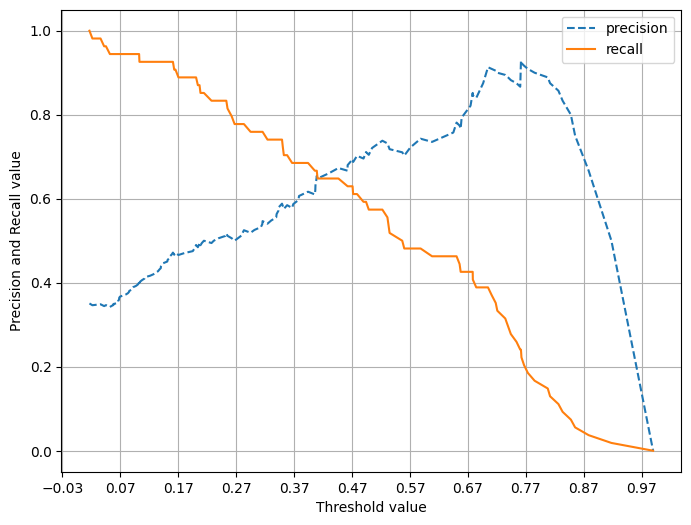

In [19]:
precision_recall_curve_plot(y_test, pred_proba)

- 정밀도 재현율 트레이드오프는 0.42 정도임
    - 문제는 0.42를 임계값으로 잡으면 정밀도/재현율 수치가 너무 낮아짐(0.7도 안되는 수치)
    - 이런 경우는 임계값 조정 전에 데이터 값 점검

**각 피처들의 값 분포 확인**

In [21]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


1. 포도당, 혈압, 피하지방 등의 수치가 0이 나올 수 없음 - 전처리 필요함

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

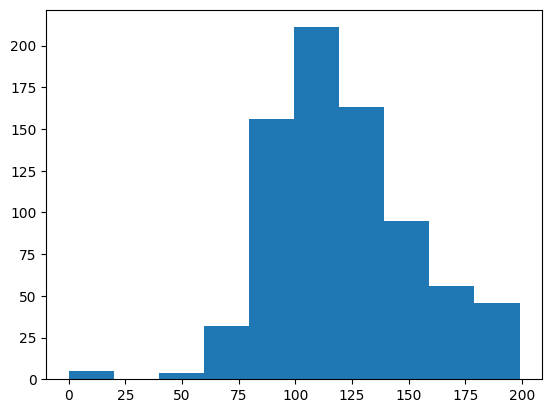

In [23]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [11]:
# 인덱싱에 사용하려고 컬럼명 출력
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**0값이 있는 피처들에서 0값의 데이터 건수와 퍼센트 계산**
- 0 값의 데이터 건수
- 전체 데이터 건수 대비 몇 퍼센트의 비율인지 확인

In [24]:
# 0의 비율 검사 컬럼
z_f = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']
total_count = diabetes_data['Glucose'].count() # 768개

- Insulin과 SkinThickness는 0값의 비율이 크므로 삭제해버리기에는 데이터가 작아짐
    - 0값을 평균값으로 대체

**0값을 평균값으로 대체**

In [29]:
diabetes_data[z_f] = diabetes_data[z_f].replace(0,diabetes_data[z_f].mean())

In [28]:
for f in z_f :
    z_c = diabetes_data[diabetes_data[f]==0][f].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(f,z_c,100*z_c/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


**StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용하고   
0값을 평균값으로 대체한 데이터 세트로 학습/예측**

StandardScaler : 표준화 지원 클래스
- 개별 피처를 가우시안 정규분포를 가질 수 있도록
- 평균이 0이고, 분산이 1인 값으로 변환

In [34]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

# 표준화 변환
scaler = StandardScaler()
X_sclaed = scaler.fit_transform(X)

# 학습/테스트 데이터 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)

# roc_auc_score도 계산하기 위해 pred_proba 변수 생성
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , pred, pred_proba)

# 재현율의 수치가 여전히 낮으므로 개선이 필요함

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


**분류결정 임계값을 변화시키면서 재현율 성능 측정**
- 임계값을 0.3에서 0.5까지 0.03씩 변화시키면서
- 재현율과 다른 평가 지표의 값 변화 확인

In [35]:
from sklearn.preprocessing import Binarizer

# 임계값에 따른 평가 수치 출력 함수
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임곗값:',custom_threshold)
        # roc_auc_score 관련 수정
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [38]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)
get_eval_by_threshold(y_test , pred_proba, thresholds)


임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433

임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433

임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433

임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433

임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433


In [ ]:
평가 정리

이진 분류에서 정밀도, 재현율, F1 스코어 AUC 스코어가 주로 성능 평가 지표로 활용

특히 이진 분류의 레이블 값이 불균형하게 분포될 경우  
(0이 매우 많고, 1이 매우 적을 경우 또는 반대의 경우)  
단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도만으로는  
머신러닝 모델의 예측 성능을 평가할 수 없음

오차 행렬은 실제 클래스 값과 예측 클래스 값의 True, False에 따라   
TN, FP, FN, TP로 맵핑되는 4분면 행렬을 기반으로 예측 성능을 평가
정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP 값을 다양하게 결합해서 만들어지며
이를 통해 분류 모델 예측 성능의 오류가 어떠한 모습으로 발생하는지 알 수 있음

정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 지표이며
분류 결정 임계값을 조정해서 정밀도 또는 재현율의 수치를 높이거나 낮출 수 있음


F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 좋은 값을 가짐

ROC-AUC는 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표 
AUC 스코어는 ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치